# Face Generation
In this project, you'll use generative adversarial networks to generate new images of faces.
### Get the Data
You'll be using two datasets in this project:
- MNIST
- CelebA

Since the celebA dataset is complex and you're doing GANs in a project for the first time, we want you to test your neural network on MNIST before CelebA.  Running the GANs on MNIST will allow you to see how well your model trains sooner.

If you're using [FloydHub](https://www.floydhub.com/), set `data_dir` to "/input" and use the [FloydHub data ID](http://docs.floydhub.com/home/using_datasets/) "R5KrjnANiKVhLWAkpXhNBe".

In [13]:
data_dir = './data'

# FloydHub - Use with data ID "R5KrjnANiKVhLWAkpXhNBe"
#data_dir = '/input'


"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import helper

helper.download_extract('mnist', data_dir)
helper.download_extract('celeba', data_dir)

Found mnist Data
Found celeba Data


## Explore the Data
### MNIST
As you're aware, the [MNIST](http://yann.lecun.com/exdb/mnist/) dataset contains images of handwritten digits. You can view the first number of examples by changing `show_n_images`. 

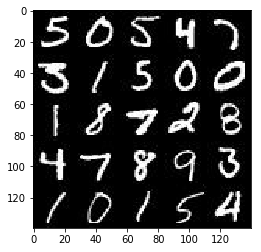

In [14]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
%matplotlib inline
import os
from glob import glob
from matplotlib import pyplot

mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'mnist/*.jpg'))[:show_n_images], 28, 28, 'L')
pyplot.imshow(helper.images_square_grid(mnist_images, 'L'), cmap='gray')

### CelebA
The [CelebFaces Attributes Dataset (CelebA)](http://mmlab.ie.cuhk.edu.hk/projects/CelebA.html) dataset contains over 200,000 celebrity images with annotations.  Since you're going to be generating faces, you won't need the annotations.  You can view the first number of examples by changing `show_n_images`.

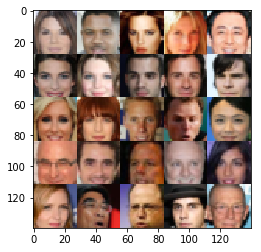

In [15]:
show_n_images = 25

"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
mnist_images = helper.get_batch(glob(os.path.join(data_dir, 'img_align_celeba/*.jpg'))[:show_n_images], 28, 28, 'RGB')
pyplot.imshow(helper.images_square_grid(mnist_images, 'RGB'))

## Preprocess the Data
Since the project's main focus is on building the GANs, we'll preprocess the data for you.  The values of the MNIST and CelebA dataset will be in the range of -0.5 to 0.5 of 28x28 dimensional images.  The CelebA images will be cropped to remove parts of the image that don't include a face, then resized down to 28x28.

The MNIST images are black and white images with a single [color channel](https://en.wikipedia.org/wiki/Channel_(digital_image%29) while the CelebA images have [3 color channels (RGB color channel)](https://en.wikipedia.org/wiki/Channel_(digital_image%29#RGB_Images).
## Build the Neural Network
You'll build the components necessary to build a GANs by implementing the following functions below:
- `model_inputs`
- `discriminator`
- `generator`
- `model_loss`
- `model_opt`
- `train`

### Check the Version of TensorFlow and Access to GPU
This will check to make sure you have the correct version of TensorFlow and access to a GPU

In [16]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
from distutils.version import LooseVersion
import warnings
import tensorflow as tf

# Check TensorFlow Version
assert LooseVersion(tf.__version__) >= LooseVersion('1.0'), 'Please use TensorFlow version 1.0 or newer.  You are using {}'.format(tf.__version__)
print('TensorFlow Version: {}'.format(tf.__version__))

# Check for a GPU
if not tf.test.gpu_device_name():
    warnings.warn('No GPU found. Please use a GPU to train your neural network.')
else:
    print('Default GPU Device: {}'.format(tf.test.gpu_device_name()))

TensorFlow Version: 1.0.0
Default GPU Device: /gpu:0


### Input
Implement the `model_inputs` function to create TF Placeholders for the Neural Network. It should create the following placeholders:
- Real input images placeholder with rank 4 using `image_width`, `image_height`, and `image_channels`.
- Z input placeholder with rank 2 using `z_dim`.
- Learning rate placeholder with rank 0.

Return the placeholders in the following the tuple (tensor of real input images, tensor of z data)

In [17]:
import problem_unittests as tests

def model_inputs(image_width, image_height, image_channels, z_dim):
    """
    Create the model inputs
    :param image_width: The input image width
    :param image_height: The input image height
    :param image_channels: The number of image channels
    :param z_dim: The dimension of Z
    :return: Tuple of (tensor of real input images, tensor of z data, learning rate)
    """
    # TODO: Implement Function
    
    inputs_real = tf.placeholder(tf.float32, shape=(None, image_width, image_height, image_channels))
    inputs_z = tf.placeholder(tf.float32, shape=(None, z_dim))
    learning_rate = tf.placeholder(tf.float32)

    return inputs_real, inputs_z, learning_rate


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_inputs(model_inputs)

Tests Passed


### Discriminator
Implement `discriminator` to create a discriminator neural network that discriminates on `images`.  This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "discriminator" to allow the variables to be reused.  The function should return a tuple of (tensor output of the discriminator, tensor logits of the discriminator).

In [18]:
def discriminator(images, reuse=False, alpha=0.2, training=True):
    """
    Create the discriminator network
    :param images: Tensor of input image(s)
    :param reuse: Boolean if the weights should be reused
    :return: Tuple of (tensor output of the discriminator, tensor logits of the discriminator)
    """
    # TODO: Implement Function
    with tf.variable_scope('discriminator', reuse=reuse):
        
        # input images are 28x28x[1 or 3]
        x1 = tf.layers.conv2d(images, 64, 5, strides=2, padding="same")
        x1 = tf.maximum(x1*alpha, x1)
        # 14x14x32
        
        x2 = tf.layers.conv2d(x1, 128, 5, strides=2, padding="same")
        x2 = tf.layers.batch_normalization(x2, training=training)
        x2 = tf.maximum(x2*alpha, x2)
        # 7x7x64
        
        x3 = tf.layers.conv2d(x2, 256, 5, strides=1, padding="valid")
        x3 = tf.layers.batch_normalization(x3, training=training)
        x3 = tf.maximum(x3*alpha, x3)
        # 7x7x256

#         print("Discrim final layer shape: {}".format(tf.shape(x3)))
        
        flatten = tf.reshape(x2, (-1, 7*7*128))
        
        logits = tf.layers.dense(flatten, 1)
        output = tf.sigmoid(logits)

    return output, logits


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_discriminator(discriminator, tf)

Tests Passed


### Generator
Implement `generator` to generate an image using `z`. This function should be able to reuse the variables in the neural network.  Use [`tf.variable_scope`](https://www.tensorflow.org/api_docs/python/tf/variable_scope) with a scope name of "generator" to allow the variables to be reused. The function should return the generated 28 x 28 x `out_channel_dim` images.

In [19]:
def generator(z, out_channel_dim, is_train=True, alpha=0.2):
    """
    Create the generator network
    :param z: Input z
    :param out_channel_dim: The number of channels in the output image
    :param is_train: Boolean if generator is being used for training
    :return: The tensor output of the generator
    """
    # TODO: Implement Function
    with tf.variable_scope('generator', reuse= not is_train):
        
        # First layer, fully connected
        fc = tf.layers.dense(z, 7*7*1024, use_bias=False)
        fc = tf.reshape(fc, (-1, 7, 7, 1024))
        fc = tf.maximum(alpha*fc, fc)
        
        # Second layer, conv transpose, 14x14x512
        x1 = tf.layers.conv2d_transpose(fc, 512, 5, strides=2, padding="same", use_bias=False)
        x1 = tf.layers.batch_normalization(x1, training=is_train)
        x1 = tf.maximum(alpha*x1, x1)
        
        # 3rd layer, conv transpose, 14x14x256
        x2 = tf.layers.conv2d_transpose(x1, 256, 5, strides=1, padding="same", use_bias=False)
        x2 = tf.layers.batch_normalization(x2, training=is_train)
        x2 = tf.maximum(alpha*x2, x2)
        
        # 4th layer, conv transpose, 14x14x128
        x3 = tf.layers.conv2d_transpose(x2, 128, 5, strides=1, padding="same", use_bias=False)
        x3 = tf.layers.batch_normalization(x3, training=is_train)
        x3 = tf.maximum(alpha*x3, x3)
        
        # Output layer, conv transpose, 28x28xout_channel_dim
        logits = tf.layers.conv2d_transpose(x3, out_channel_dim, 5, strides=2, padding="same", use_bias=False)
        output = tf.tanh(logits)
    
    return output


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_generator(generator, tf)

Tests Passed


### Loss
Implement `model_loss` to build the GANs for training and calculate the loss.  The function should return a tuple of (discriminator loss, generator loss).  Use the following functions you implemented:
- `discriminator(images, reuse=False)`
- `generator(z, out_channel_dim, is_train=True)`

In [26]:
def model_loss(input_real, input_z, out_channel_dim, alpha=0.2, smooth=0.1):
    """
    Get the loss for the discriminator and generator
    :param input_real: Images from the real dataset
    :param input_z: Z input
    :param out_channel_dim: The number of channels in the output image
    :return: A tuple of (discriminator loss, generator loss)
    """
    # TODO: Implement Function
    g_model = generator(input_z, out_channel_dim, is_train=True, alpha=alpha)
    d_model_real, d_logits_real = discriminator(input_real, reuse=False, alpha=alpha)
    d_model_fake, d_logits_fake = discriminator(g_model, reuse=True, alpha=alpha)
    
    d_loss_real = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_real, labels=tf.ones_like(d_model_real) * (1 - smooth)))
    d_loss_fake = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.zeros_like(d_model_fake)))
    g_loss = tf.reduce_mean(
        tf.nn.sigmoid_cross_entropy_with_logits(logits=d_logits_fake, labels=tf.ones_like(d_model_fake) * (1 - smooth)))
    
    d_loss = d_loss_real + d_loss_fake
    
    return d_loss, g_loss


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_loss(model_loss)

Tests Passed


### Optimization
Implement `model_opt` to create the optimization operations for the GANs. Use [`tf.trainable_variables`](https://www.tensorflow.org/api_docs/python/tf/trainable_variables) to get all the trainable variables.  Filter the variables with names that are in the discriminator and generator scope names.  The function should return a tuple of (discriminator training operation, generator training operation).

In [21]:
def model_opt(d_loss, g_loss, learning_rate, beta1):
    """
    Get optimization operations
    :param d_loss: Discriminator loss Tensor
    :param g_loss: Generator loss Tensor
    :param learning_rate: Learning Rate Placeholder
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :return: A tuple of (discriminator training operation, generator training operation)
    """
    # TODO: Implement Function
    
    t_vars = tf.trainable_variables()
    d_vars = [var for var in t_vars if var.name.startswith('discriminator')]
    g_vars = [var for var in t_vars if var.name.startswith('generator')]
    
    update_ops = tf.get_collection(tf.GraphKeys.UPDATE_OPS)
    
    with tf.control_dependencies(update_ops):
        d_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(d_loss, var_list=d_vars)
        g_train_opt = tf.train.AdamOptimizer(learning_rate, beta1=beta1).minimize(g_loss, var_list=g_vars)
    
    return d_train_opt, g_train_opt


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
tests.test_model_opt(model_opt, tf)

Tests Passed


## Neural Network Training
### Show Output
Use this function to show the current output of the generator during training. It will help you determine how well the GANs is training.

In [22]:
"""
DON'T MODIFY ANYTHING IN THIS CELL
"""
import numpy as np

def show_generator_output(sess, n_images, input_z, out_channel_dim, image_mode):
    """
    Show example output for the generator
    :param sess: TensorFlow session
    :param n_images: Number of Images to display
    :param input_z: Input Z Tensor
    :param out_channel_dim: The number of channels in the output image
    :param image_mode: The mode to use for images ("RGB" or "L")
    """
    cmap = None if image_mode == 'RGB' else 'gray'
    z_dim = input_z.get_shape().as_list()[-1]
    example_z = np.random.uniform(-1, 1, size=[n_images, z_dim])

    samples = sess.run(
        generator(input_z, out_channel_dim, False),
        feed_dict={input_z: example_z})

    images_grid = helper.images_square_grid(samples, image_mode)
    pyplot.imshow(images_grid, cmap=cmap)
    pyplot.show()

### Train
Implement `train` to build and train the GANs.  Use the following functions you implemented:
- `model_inputs(image_width, image_height, image_channels, z_dim)`
- `model_loss(input_real, input_z, out_channel_dim)`
- `model_opt(d_loss, g_loss, learning_rate, beta1)`

Use the `show_generator_output` to show `generator` output while you train. Running `show_generator_output` for every batch will drastically increase training time and increase the size of the notebook.  It's recommended to print the `generator` output every 100 batches.

In [23]:
def train(epoch_count, batch_size, z_dim, learning_rate, beta1, get_batches, data_shape, data_image_mode):
    """
    Train the GAN
    :param epoch_count: Number of epochs
    :param batch_size: Batch Size
    :param z_dim: Z dimension
    :param learning_rate: Learning Rate
    :param beta1: The exponential decay rate for the 1st moment in the optimizer
    :param get_batches: Function to get batches
    :param data_shape: Shape of the data
    :param data_image_mode: The image mode to use for images ("RGB" or "L")
    """
    # TODO: Build Model
    
    inputs_real, inputs_z, l_rate = model_inputs(data_shape[1], data_shape[2], data_shape[3], z_dim)
    d_loss, g_loss = model_loss(inputs_real, inputs_z, data_shape[3])
    d_opt, g_opt = model_opt(d_loss, g_loss, learning_rate, beta1)
    
    saver = tf.train.Saver()
    sample_z = np.random.uniform(-0.5, 0.5, size=(batch_size, z_dim))
    steps = 0
    print_every = 10
    show_every = 100
    samples, losses = [], []
    
    with tf.Session() as sess:
        sess.run(tf.global_variables_initializer())
        for epoch_i in range(epoch_count):
            for batch_images in get_batches(batch_size):
                # TODO: Train Model
                steps += 1
                
                # Scaling up the image values to match the tanh
                batch_images = batch_images * 2
                
                # Sample random noise for G
                batch_z = np.random.uniform(-0.5, 0.5, size=(batch_size, z_dim))
                
                # Run optimisers
                _ = sess.run(d_opt, feed_dict={inputs_real: batch_images, inputs_z: batch_z, l_rate:learning_rate})
                _ = sess.run(g_opt, feed_dict={inputs_z: batch_z, inputs_real: batch_images, l_rate:learning_rate})
                _ = sess.run(g_opt, feed_dict={inputs_z: batch_z, inputs_real: batch_images, l_rate:learning_rate})
                
                # Print losses
                if steps % print_every == 0:
                    # At the end of every epoch, print the losses
                    train_loss_d = d_loss.eval({inputs_z: batch_z, inputs_real: batch_images})
                    train_loss_g = g_loss.eval({inputs_z: batch_z})
                    
                    print("Epoch {}/{}...".format(epoch_i+1, epoch_count),
                          "Discriminator Loss: {:.4f}...".format(train_loss_d),
                          "Generator Loss: {:.4f}".format(train_loss_g)
                         )
                    
                    losses.append((train_loss_d, train_loss_g))
                    
                # Show mid-training images 
                if steps % show_every == 0:
                    show_generator_output(sess, 20, inputs_z, data_shape[3], data_image_mode)
                
        saver.save(sess, 'checkpoints/generator.ckpt')
        
    return losses, samples

### MNIST
Test your GANs architecture on MNIST.  After 2 epochs, the GANs should be able to generate images that look like handwritten digits.  Make sure the loss of the generator is lower than the loss of the discriminator or close to 0.

In [ ]:
batch_size = 32
z_dim = 100
learning_rate = 0.0008
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 2

mnist_dataset = helper.Dataset('mnist', glob(os.path.join(data_dir, 'mnist/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, mnist_dataset.get_batches,
          mnist_dataset.shape, mnist_dataset.image_mode)

### CelebA
Run your GANs on CelebA.  It will take around 20 minutes on the average GPU to run one epoch.  You can run the whole epoch or stop when it starts to generate realistic faces.

Epoch 1/1... Discriminator Loss: 2.9035... Generator Loss: 0.3308
Epoch 1/1... Discriminator Loss: 4.9321... Generator Loss: 0.3787
Epoch 1/1... Discriminator Loss: 4.5961... Generator Loss: 0.3504
Epoch 1/1... Discriminator Loss: 4.6738... Generator Loss: 0.3429
Epoch 1/1... Discriminator Loss: 3.2801... Generator Loss: 0.5017
Epoch 1/1... Discriminator Loss: 3.6727... Generator Loss: 0.3566
Epoch 1/1... Discriminator Loss: 1.7892... Generator Loss: 0.6736
Epoch 1/1... Discriminator Loss: 2.2561... Generator Loss: 0.4783
Epoch 1/1... Discriminator Loss: 2.3727... Generator Loss: 0.4669
Epoch 1/1... Discriminator Loss: 2.1939... Generator Loss: 0.4835


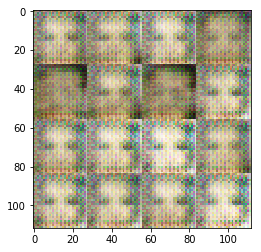

Epoch 1/1... Discriminator Loss: 2.2141... Generator Loss: 0.4896
Epoch 1/1... Discriminator Loss: 1.8935... Generator Loss: 0.4898
Epoch 1/1... Discriminator Loss: 1.9022... Generator Loss: 0.8652
Epoch 1/1... Discriminator Loss: 1.9123... Generator Loss: 0.5600
Epoch 1/1... Discriminator Loss: 2.0809... Generator Loss: 0.5583
Epoch 1/1... Discriminator Loss: 2.0059... Generator Loss: 0.4689
Epoch 1/1... Discriminator Loss: 2.0640... Generator Loss: 0.4338
Epoch 1/1... Discriminator Loss: 1.8703... Generator Loss: 0.5542
Epoch 1/1... Discriminator Loss: 2.1561... Generator Loss: 0.4607
Epoch 1/1... Discriminator Loss: 1.9051... Generator Loss: 0.5101


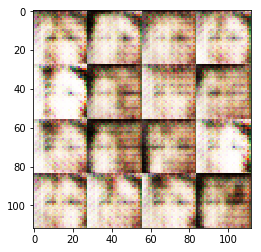

Epoch 1/1... Discriminator Loss: 2.1933... Generator Loss: 0.7254
Epoch 1/1... Discriminator Loss: 1.7022... Generator Loss: 0.8234
Epoch 1/1... Discriminator Loss: 1.9314... Generator Loss: 0.6753
Epoch 1/1... Discriminator Loss: 1.6325... Generator Loss: 0.6154
Epoch 1/1... Discriminator Loss: 2.2328... Generator Loss: 0.4171
Epoch 1/1... Discriminator Loss: 1.4947... Generator Loss: 0.6868
Epoch 1/1... Discriminator Loss: 2.0418... Generator Loss: 0.4646
Epoch 1/1... Discriminator Loss: 1.7393... Generator Loss: 0.5859
Epoch 1/1... Discriminator Loss: 1.7370... Generator Loss: 0.6384
Epoch 1/1... Discriminator Loss: 1.6072... Generator Loss: 0.7174


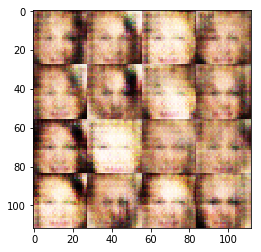

Epoch 1/1... Discriminator Loss: 1.8025... Generator Loss: 0.6025
Epoch 1/1... Discriminator Loss: 1.6151... Generator Loss: 0.6240
Epoch 1/1... Discriminator Loss: 1.6045... Generator Loss: 0.6071
Epoch 1/1... Discriminator Loss: 1.6847... Generator Loss: 0.6421
Epoch 1/1... Discriminator Loss: 1.6421... Generator Loss: 0.6792
Epoch 1/1... Discriminator Loss: 1.6741... Generator Loss: 0.7339
Epoch 1/1... Discriminator Loss: 1.5063... Generator Loss: 0.6459
Epoch 1/1... Discriminator Loss: 1.6737... Generator Loss: 0.5918
Epoch 1/1... Discriminator Loss: 1.6384... Generator Loss: 0.6295
Epoch 1/1... Discriminator Loss: 1.7577... Generator Loss: 0.6158


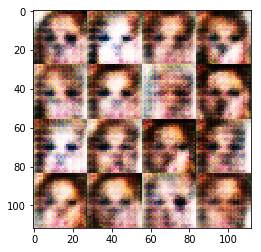

Epoch 1/1... Discriminator Loss: 1.8927... Generator Loss: 0.5278
Epoch 1/1... Discriminator Loss: 1.7782... Generator Loss: 0.7054
Epoch 1/1... Discriminator Loss: 1.7788... Generator Loss: 0.6564
Epoch 1/1... Discriminator Loss: 1.8383... Generator Loss: 0.5736
Epoch 1/1... Discriminator Loss: 1.7781... Generator Loss: 0.5217
Epoch 1/1... Discriminator Loss: 1.3822... Generator Loss: 0.6951
Epoch 1/1... Discriminator Loss: 1.6170... Generator Loss: 0.5999
Epoch 1/1... Discriminator Loss: 1.6533... Generator Loss: 0.8148
Epoch 1/1... Discriminator Loss: 1.7556... Generator Loss: 0.7590
Epoch 1/1... Discriminator Loss: 1.8542... Generator Loss: 0.5246


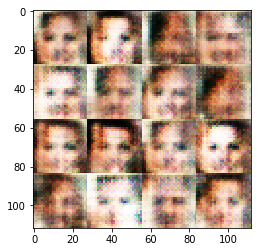

Epoch 1/1... Discriminator Loss: 1.5791... Generator Loss: 0.6012
Epoch 1/1... Discriminator Loss: 1.6795... Generator Loss: 0.6363
Epoch 1/1... Discriminator Loss: 1.7186... Generator Loss: 0.6179
Epoch 1/1... Discriminator Loss: 2.0556... Generator Loss: 0.4950
Epoch 1/1... Discriminator Loss: 1.7337... Generator Loss: 0.5541
Epoch 1/1... Discriminator Loss: 1.5402... Generator Loss: 0.6682
Epoch 1/1... Discriminator Loss: 1.5808... Generator Loss: 0.7665
Epoch 1/1... Discriminator Loss: 1.7292... Generator Loss: 0.7014
Epoch 1/1... Discriminator Loss: 1.4622... Generator Loss: 0.7420
Epoch 1/1... Discriminator Loss: 1.8809... Generator Loss: 0.5606


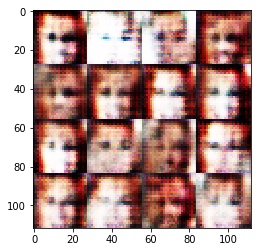

Epoch 1/1... Discriminator Loss: 1.6700... Generator Loss: 0.6557
Epoch 1/1... Discriminator Loss: 1.7364... Generator Loss: 0.6038
Epoch 1/1... Discriminator Loss: 1.5468... Generator Loss: 0.6928
Epoch 1/1... Discriminator Loss: 1.5101... Generator Loss: 0.6862
Epoch 1/1... Discriminator Loss: 1.5772... Generator Loss: 0.6249
Epoch 1/1... Discriminator Loss: 1.4720... Generator Loss: 0.7005
Epoch 1/1... Discriminator Loss: 2.0085... Generator Loss: 0.4995
Epoch 1/1... Discriminator Loss: 1.6791... Generator Loss: 0.5938
Epoch 1/1... Discriminator Loss: 1.6142... Generator Loss: 0.7957
Epoch 1/1... Discriminator Loss: 1.5373... Generator Loss: 0.6949


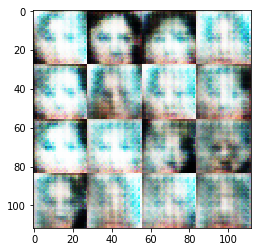

Epoch 1/1... Discriminator Loss: 1.5411... Generator Loss: 0.6010
Epoch 1/1... Discriminator Loss: 1.7329... Generator Loss: 0.5845
Epoch 1/1... Discriminator Loss: 1.5718... Generator Loss: 0.7739
Epoch 1/1... Discriminator Loss: 1.6030... Generator Loss: 0.7219
Epoch 1/1... Discriminator Loss: 1.6232... Generator Loss: 0.6210
Epoch 1/1... Discriminator Loss: 1.5314... Generator Loss: 0.6499
Epoch 1/1... Discriminator Loss: 1.6243... Generator Loss: 0.7095
Epoch 1/1... Discriminator Loss: 1.5393... Generator Loss: 0.7172
Epoch 1/1... Discriminator Loss: 1.4817... Generator Loss: 0.7324
Epoch 1/1... Discriminator Loss: 1.6012... Generator Loss: 0.6829


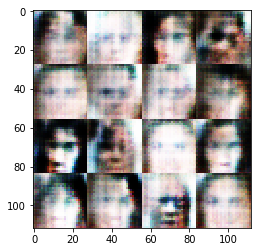

Epoch 1/1... Discriminator Loss: 1.6058... Generator Loss: 0.7063
Epoch 1/1... Discriminator Loss: 1.5926... Generator Loss: 0.6289
Epoch 1/1... Discriminator Loss: 1.6801... Generator Loss: 0.5537
Epoch 1/1... Discriminator Loss: 1.4898... Generator Loss: 0.6985
Epoch 1/1... Discriminator Loss: 1.4662... Generator Loss: 0.7377
Epoch 1/1... Discriminator Loss: 1.5570... Generator Loss: 0.6743
Epoch 1/1... Discriminator Loss: 1.5125... Generator Loss: 0.6989
Epoch 1/1... Discriminator Loss: 1.5401... Generator Loss: 0.6564
Epoch 1/1... Discriminator Loss: 1.6371... Generator Loss: 0.6568
Epoch 1/1... Discriminator Loss: 1.9436... Generator Loss: 0.4811


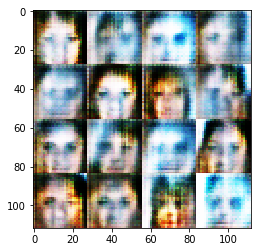

Epoch 1/1... Discriminator Loss: 1.7163... Generator Loss: 0.5673
Epoch 1/1... Discriminator Loss: 1.4250... Generator Loss: 0.7377
Epoch 1/1... Discriminator Loss: 1.5617... Generator Loss: 0.6228
Epoch 1/1... Discriminator Loss: 1.6255... Generator Loss: 0.6607
Epoch 1/1... Discriminator Loss: 1.7930... Generator Loss: 0.5989
Epoch 1/1... Discriminator Loss: 1.7835... Generator Loss: 0.5391
Epoch 1/1... Discriminator Loss: 1.7404... Generator Loss: 0.6522
Epoch 1/1... Discriminator Loss: 1.4593... Generator Loss: 0.7642
Epoch 1/1... Discriminator Loss: 1.6346... Generator Loss: 0.6587
Epoch 1/1... Discriminator Loss: 1.4146... Generator Loss: 0.7690


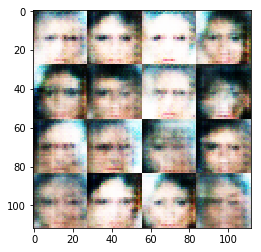

Epoch 1/1... Discriminator Loss: 1.4636... Generator Loss: 0.7081
Epoch 1/1... Discriminator Loss: 1.4946... Generator Loss: 0.6674
Epoch 1/1... Discriminator Loss: 1.6198... Generator Loss: 0.6814
Epoch 1/1... Discriminator Loss: 1.6898... Generator Loss: 0.6529
Epoch 1/1... Discriminator Loss: 1.6826... Generator Loss: 0.6347
Epoch 1/1... Discriminator Loss: 1.5260... Generator Loss: 0.7015
Epoch 1/1... Discriminator Loss: 1.5274... Generator Loss: 0.6062
Epoch 1/1... Discriminator Loss: 1.5905... Generator Loss: 0.7193
Epoch 1/1... Discriminator Loss: 1.6937... Generator Loss: 0.7267
Epoch 1/1... Discriminator Loss: 1.7011... Generator Loss: 0.5825


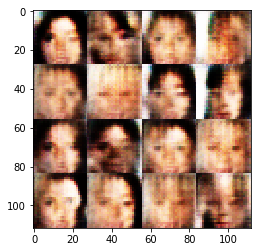

Epoch 1/1... Discriminator Loss: 1.7718... Generator Loss: 0.6881
Epoch 1/1... Discriminator Loss: 1.5497... Generator Loss: 0.6186
Epoch 1/1... Discriminator Loss: 1.5821... Generator Loss: 0.6031
Epoch 1/1... Discriminator Loss: 1.6918... Generator Loss: 0.5962
Epoch 1/1... Discriminator Loss: 1.4829... Generator Loss: 0.7273
Epoch 1/1... Discriminator Loss: 1.5227... Generator Loss: 0.6783
Epoch 1/1... Discriminator Loss: 1.6078... Generator Loss: 0.6321
Epoch 1/1... Discriminator Loss: 1.5350... Generator Loss: 0.6563
Epoch 1/1... Discriminator Loss: 1.6481... Generator Loss: 0.6253
Epoch 1/1... Discriminator Loss: 1.7144... Generator Loss: 0.6293


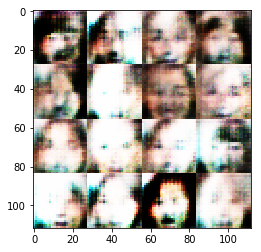

Epoch 1/1... Discriminator Loss: 1.8344... Generator Loss: 0.7213
Epoch 1/1... Discriminator Loss: 1.5209... Generator Loss: 0.8144
Epoch 1/1... Discriminator Loss: 1.6718... Generator Loss: 0.6560
Epoch 1/1... Discriminator Loss: 1.5780... Generator Loss: 0.6979
Epoch 1/1... Discriminator Loss: 1.7493... Generator Loss: 0.6028
Epoch 1/1... Discriminator Loss: 1.4922... Generator Loss: 0.6620
Epoch 1/1... Discriminator Loss: 1.5975... Generator Loss: 0.6937
Epoch 1/1... Discriminator Loss: 1.6466... Generator Loss: 0.7313
Epoch 1/1... Discriminator Loss: 1.6075... Generator Loss: 0.6993
Epoch 1/1... Discriminator Loss: 1.5273... Generator Loss: 0.7198


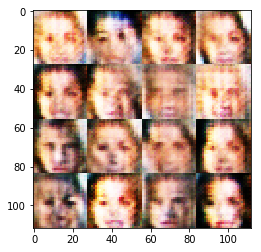

Epoch 1/1... Discriminator Loss: 1.5072... Generator Loss: 0.8497
Epoch 1/1... Discriminator Loss: 1.6653... Generator Loss: 0.7766
Epoch 1/1... Discriminator Loss: 1.7051... Generator Loss: 0.8236
Epoch 1/1... Discriminator Loss: 1.4892... Generator Loss: 0.7282
Epoch 1/1... Discriminator Loss: 1.4299... Generator Loss: 0.8555
Epoch 1/1... Discriminator Loss: 1.5144... Generator Loss: 0.6162
Epoch 1/1... Discriminator Loss: 1.5932... Generator Loss: 0.6683
Epoch 1/1... Discriminator Loss: 1.5333... Generator Loss: 0.7018
Epoch 1/1... Discriminator Loss: 1.5397... Generator Loss: 0.7307
Epoch 1/1... Discriminator Loss: 1.5138... Generator Loss: 0.6829


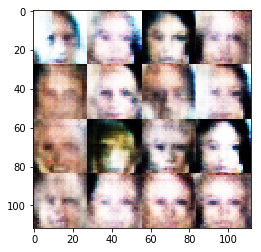

Epoch 1/1... Discriminator Loss: 1.5310... Generator Loss: 0.7445
Epoch 1/1... Discriminator Loss: 1.4545... Generator Loss: 0.7235
Epoch 1/1... Discriminator Loss: 1.5611... Generator Loss: 0.6135
Epoch 1/1... Discriminator Loss: 1.4453... Generator Loss: 0.6803
Epoch 1/1... Discriminator Loss: 1.6465... Generator Loss: 0.6922
Epoch 1/1... Discriminator Loss: 1.6147... Generator Loss: 0.6396
Epoch 1/1... Discriminator Loss: 1.6376... Generator Loss: 0.5829
Epoch 1/1... Discriminator Loss: 1.4804... Generator Loss: 0.7010
Epoch 1/1... Discriminator Loss: 1.5951... Generator Loss: 0.7019
Epoch 1/1... Discriminator Loss: 1.7053... Generator Loss: 0.6120


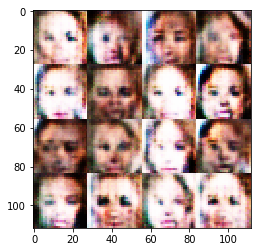

Epoch 1/1... Discriminator Loss: 1.6642... Generator Loss: 0.5840
Epoch 1/1... Discriminator Loss: 1.4879... Generator Loss: 0.7220
Epoch 1/1... Discriminator Loss: 1.6015... Generator Loss: 0.6722
Epoch 1/1... Discriminator Loss: 1.6423... Generator Loss: 0.5728
Epoch 1/1... Discriminator Loss: 1.4733... Generator Loss: 0.8120
Epoch 1/1... Discriminator Loss: 1.4584... Generator Loss: 0.8444
Epoch 1/1... Discriminator Loss: 1.5578... Generator Loss: 0.6972
Epoch 1/1... Discriminator Loss: 1.5354... Generator Loss: 0.6305
Epoch 1/1... Discriminator Loss: 1.5114... Generator Loss: 0.6921
Epoch 1/1... Discriminator Loss: 1.5083... Generator Loss: 0.7426


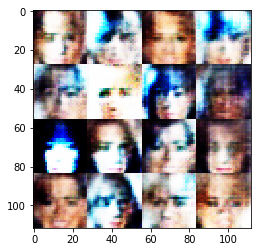

Epoch 1/1... Discriminator Loss: 1.4709... Generator Loss: 0.7203
Epoch 1/1... Discriminator Loss: 1.4753... Generator Loss: 0.6244
Epoch 1/1... Discriminator Loss: 1.5629... Generator Loss: 0.6995
Epoch 1/1... Discriminator Loss: 1.5079... Generator Loss: 0.6581
Epoch 1/1... Discriminator Loss: 1.5215... Generator Loss: 0.6665
Epoch 1/1... Discriminator Loss: 1.5270... Generator Loss: 0.6573
Epoch 1/1... Discriminator Loss: 1.5373... Generator Loss: 0.7250
Epoch 1/1... Discriminator Loss: 1.4617... Generator Loss: 0.7240
Epoch 1/1... Discriminator Loss: 1.6019... Generator Loss: 0.6557
Epoch 1/1... Discriminator Loss: 1.4581... Generator Loss: 0.6519


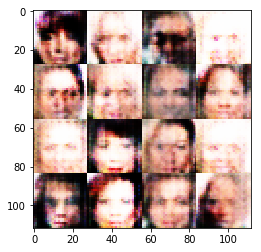

Epoch 1/1... Discriminator Loss: 1.8082... Generator Loss: 0.5607
Epoch 1/1... Discriminator Loss: 1.6706... Generator Loss: 0.6399
Epoch 1/1... Discriminator Loss: 1.6254... Generator Loss: 0.6783
Epoch 1/1... Discriminator Loss: 1.4618... Generator Loss: 0.6895
Epoch 1/1... Discriminator Loss: 1.4489... Generator Loss: 0.6446
Epoch 1/1... Discriminator Loss: 1.6047... Generator Loss: 0.7780
Epoch 1/1... Discriminator Loss: 1.4924... Generator Loss: 0.6641
Epoch 1/1... Discriminator Loss: 1.5967... Generator Loss: 0.6757
Epoch 1/1... Discriminator Loss: 1.5758... Generator Loss: 0.6504
Epoch 1/1... Discriminator Loss: 1.5412... Generator Loss: 0.6428


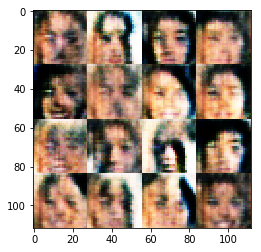

Epoch 1/1... Discriminator Loss: 1.6086... Generator Loss: 0.6453
Epoch 1/1... Discriminator Loss: 1.7386... Generator Loss: 0.5754
Epoch 1/1... Discriminator Loss: 1.4691... Generator Loss: 0.7434
Epoch 1/1... Discriminator Loss: 1.4828... Generator Loss: 0.6859
Epoch 1/1... Discriminator Loss: 1.5387... Generator Loss: 0.7270
Epoch 1/1... Discriminator Loss: 1.5774... Generator Loss: 0.6494
Epoch 1/1... Discriminator Loss: 1.5364... Generator Loss: 0.6441
Epoch 1/1... Discriminator Loss: 1.5398... Generator Loss: 0.7030
Epoch 1/1... Discriminator Loss: 1.5115... Generator Loss: 0.6759
Epoch 1/1... Discriminator Loss: 1.6893... Generator Loss: 0.6498


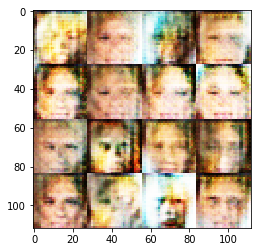

Epoch 1/1... Discriminator Loss: 1.5185... Generator Loss: 0.6312
Epoch 1/1... Discriminator Loss: 1.4844... Generator Loss: 0.8154
Epoch 1/1... Discriminator Loss: 1.6238... Generator Loss: 0.6870
Epoch 1/1... Discriminator Loss: 1.5282... Generator Loss: 0.6043
Epoch 1/1... Discriminator Loss: 1.6052... Generator Loss: 0.6020
Epoch 1/1... Discriminator Loss: 1.5612... Generator Loss: 0.6547
Epoch 1/1... Discriminator Loss: 1.5321... Generator Loss: 0.6994
Epoch 1/1... Discriminator Loss: 1.4981... Generator Loss: 0.6648
Epoch 1/1... Discriminator Loss: 1.5172... Generator Loss: 0.7845
Epoch 1/1... Discriminator Loss: 1.4269... Generator Loss: 0.7534


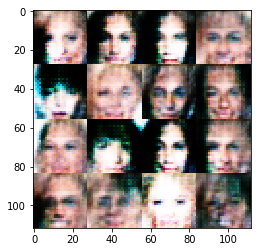

Epoch 1/1... Discriminator Loss: 1.5432... Generator Loss: 0.7070
Epoch 1/1... Discriminator Loss: 1.4334... Generator Loss: 0.7245
Epoch 1/1... Discriminator Loss: 1.6136... Generator Loss: 0.6469
Epoch 1/1... Discriminator Loss: 1.5191... Generator Loss: 0.6263
Epoch 1/1... Discriminator Loss: 1.6793... Generator Loss: 0.6546
Epoch 1/1... Discriminator Loss: 1.4889... Generator Loss: 0.6955
Epoch 1/1... Discriminator Loss: 1.5762... Generator Loss: 0.6292
Epoch 1/1... Discriminator Loss: 1.5535... Generator Loss: 0.6975
Epoch 1/1... Discriminator Loss: 1.4747... Generator Loss: 0.6749
Epoch 1/1... Discriminator Loss: 1.5202... Generator Loss: 0.6572


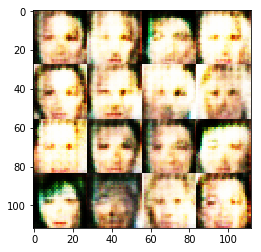

Epoch 1/1... Discriminator Loss: 1.4802... Generator Loss: 0.6572
Epoch 1/1... Discriminator Loss: 1.5219... Generator Loss: 0.6766
Epoch 1/1... Discriminator Loss: 1.4496... Generator Loss: 0.7136
Epoch 1/1... Discriminator Loss: 1.6769... Generator Loss: 0.6561
Epoch 1/1... Discriminator Loss: 1.4414... Generator Loss: 0.8421
Epoch 1/1... Discriminator Loss: 1.4119... Generator Loss: 0.7812
Epoch 1/1... Discriminator Loss: 1.5163... Generator Loss: 0.6423
Epoch 1/1... Discriminator Loss: 1.5263... Generator Loss: 0.6751
Epoch 1/1... Discriminator Loss: 1.4611... Generator Loss: 0.7546
Epoch 1/1... Discriminator Loss: 1.4767... Generator Loss: 0.6865


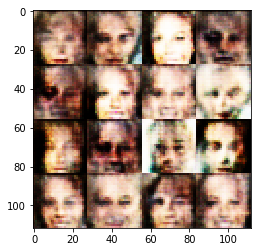

Epoch 1/1... Discriminator Loss: 1.5152... Generator Loss: 0.6690
Epoch 1/1... Discriminator Loss: 1.5084... Generator Loss: 0.6419
Epoch 1/1... Discriminator Loss: 1.5023... Generator Loss: 0.7156
Epoch 1/1... Discriminator Loss: 1.4965... Generator Loss: 0.6533
Epoch 1/1... Discriminator Loss: 1.5745... Generator Loss: 0.6632
Epoch 1/1... Discriminator Loss: 1.5063... Generator Loss: 0.7192
Epoch 1/1... Discriminator Loss: 1.5759... Generator Loss: 0.6296
Epoch 1/1... Discriminator Loss: 1.5608... Generator Loss: 0.6994
Epoch 1/1... Discriminator Loss: 1.5091... Generator Loss: 0.6241
Epoch 1/1... Discriminator Loss: 1.5097... Generator Loss: 0.6843


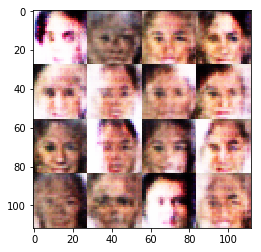

Epoch 1/1... Discriminator Loss: 1.5129... Generator Loss: 0.7018
Epoch 1/1... Discriminator Loss: 1.6291... Generator Loss: 0.6168
Epoch 1/1... Discriminator Loss: 1.7924... Generator Loss: 0.4817
Epoch 1/1... Discriminator Loss: 1.5594... Generator Loss: 0.7385
Epoch 1/1... Discriminator Loss: 1.4632... Generator Loss: 0.6888
Epoch 1/1... Discriminator Loss: 1.5071... Generator Loss: 0.7217
Epoch 1/1... Discriminator Loss: 1.4727... Generator Loss: 0.6875
Epoch 1/1... Discriminator Loss: 1.5300... Generator Loss: 0.7057
Epoch 1/1... Discriminator Loss: 1.4518... Generator Loss: 0.8603
Epoch 1/1... Discriminator Loss: 1.5520... Generator Loss: 0.6769


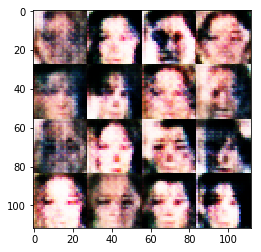

Epoch 1/1... Discriminator Loss: 1.5939... Generator Loss: 0.6131
Epoch 1/1... Discriminator Loss: 1.5225... Generator Loss: 0.7608
Epoch 1/1... Discriminator Loss: 1.4662... Generator Loss: 0.7800
Epoch 1/1... Discriminator Loss: 1.4526... Generator Loss: 0.7147
Epoch 1/1... Discriminator Loss: 1.5275... Generator Loss: 0.7171
Epoch 1/1... Discriminator Loss: 1.4306... Generator Loss: 0.6509
Epoch 1/1... Discriminator Loss: 1.4621... Generator Loss: 0.7244
Epoch 1/1... Discriminator Loss: 1.4828... Generator Loss: 0.6247
Epoch 1/1... Discriminator Loss: 1.5732... Generator Loss: 0.6271
Epoch 1/1... Discriminator Loss: 1.3818... Generator Loss: 0.7559


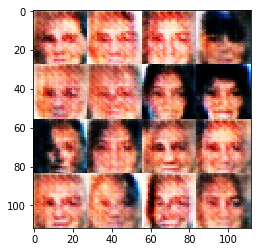

Epoch 1/1... Discriminator Loss: 1.3789... Generator Loss: 0.7238
Epoch 1/1... Discriminator Loss: 1.4998... Generator Loss: 0.7479
Epoch 1/1... Discriminator Loss: 1.4870... Generator Loss: 0.7260
Epoch 1/1... Discriminator Loss: 1.4425... Generator Loss: 0.7752
Epoch 1/1... Discriminator Loss: 1.4753... Generator Loss: 0.7270
Epoch 1/1... Discriminator Loss: 1.4225... Generator Loss: 0.7619
Epoch 1/1... Discriminator Loss: 1.4187... Generator Loss: 0.6914
Epoch 1/1... Discriminator Loss: 1.4547... Generator Loss: 0.7106
Epoch 1/1... Discriminator Loss: 1.4267... Generator Loss: 0.7833
Epoch 1/1... Discriminator Loss: 1.3936... Generator Loss: 0.7726


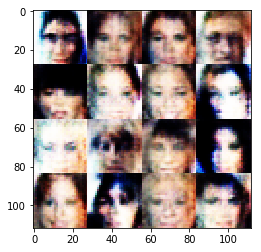

Epoch 1/1... Discriminator Loss: 1.4326... Generator Loss: 0.6936
Epoch 1/1... Discriminator Loss: 1.5585... Generator Loss: 0.6581
Epoch 1/1... Discriminator Loss: 1.5791... Generator Loss: 0.6914
Epoch 1/1... Discriminator Loss: 1.4628... Generator Loss: 0.6356
Epoch 1/1... Discriminator Loss: 1.3731... Generator Loss: 0.7612
Epoch 1/1... Discriminator Loss: 1.5362... Generator Loss: 0.6855
Epoch 1/1... Discriminator Loss: 1.5174... Generator Loss: 0.6999
Epoch 1/1... Discriminator Loss: 1.5301... Generator Loss: 0.7478
Epoch 1/1... Discriminator Loss: 1.5097... Generator Loss: 0.7122
Epoch 1/1... Discriminator Loss: 1.4871... Generator Loss: 0.7017


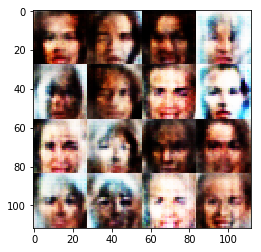

Epoch 1/1... Discriminator Loss: 1.4641... Generator Loss: 0.7328
Epoch 1/1... Discriminator Loss: 1.4819... Generator Loss: 0.7494
Epoch 1/1... Discriminator Loss: 1.4613... Generator Loss: 0.7680
Epoch 1/1... Discriminator Loss: 1.5598... Generator Loss: 0.6401
Epoch 1/1... Discriminator Loss: 1.4433... Generator Loss: 0.7900
Epoch 1/1... Discriminator Loss: 1.4745... Generator Loss: 0.6594
Epoch 1/1... Discriminator Loss: 1.5088... Generator Loss: 0.7587
Epoch 1/1... Discriminator Loss: 1.5211... Generator Loss: 0.6928
Epoch 1/1... Discriminator Loss: 1.5452... Generator Loss: 0.7959
Epoch 1/1... Discriminator Loss: 1.4927... Generator Loss: 0.6764


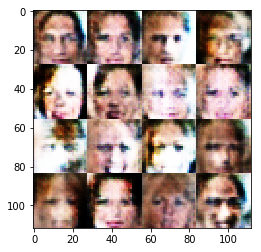

Epoch 1/1... Discriminator Loss: 1.4304... Generator Loss: 0.7682
Epoch 1/1... Discriminator Loss: 1.4913... Generator Loss: 0.6967
Epoch 1/1... Discriminator Loss: 1.4052... Generator Loss: 0.7838
Epoch 1/1... Discriminator Loss: 1.4789... Generator Loss: 0.6912
Epoch 1/1... Discriminator Loss: 1.4232... Generator Loss: 0.6875
Epoch 1/1... Discriminator Loss: 1.4130... Generator Loss: 0.7842
Epoch 1/1... Discriminator Loss: 1.5724... Generator Loss: 0.6413
Epoch 1/1... Discriminator Loss: 1.4631... Generator Loss: 0.7141


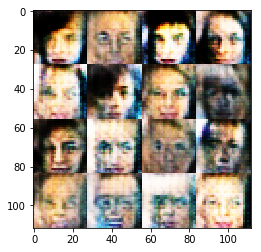

Epoch 1/1... Discriminator Loss: 1.5033... Generator Loss: 0.7516
Epoch 1/1... Discriminator Loss: 1.4737... Generator Loss: 0.7180
Epoch 1/1... Discriminator Loss: 1.4518... Generator Loss: 0.7324
Epoch 1/1... Discriminator Loss: 1.4963... Generator Loss: 0.7286
Epoch 1/1... Discriminator Loss: 1.4530... Generator Loss: 0.7499
Epoch 1/1... Discriminator Loss: 1.4259... Generator Loss: 0.7928
Epoch 1/1... Discriminator Loss: 1.4225... Generator Loss: 0.6989
Epoch 1/1... Discriminator Loss: 1.4334... Generator Loss: 0.7005
Epoch 1/1... Discriminator Loss: 1.4406... Generator Loss: 0.7259
Epoch 1/1... Discriminator Loss: 1.4621... Generator Loss: 0.7260
Epoch 1/1... Discriminator Loss: 1.5118... Generator Loss: 0.6679
Epoch 1/1... Discriminator Loss: 1.5141... Generator Loss: 0.6673
Epoch 1/1... Discriminator Loss: 1.4268... Generator Loss: 0.7337
Epoch 1/1... Discriminator Loss: 1.4078... Generator Loss: 0.7464


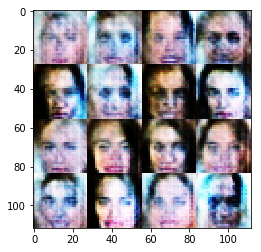

Epoch 1/1... Discriminator Loss: 1.4347... Generator Loss: 0.7892
Epoch 1/1... Discriminator Loss: 1.4277... Generator Loss: 0.7619
Epoch 1/1... Discriminator Loss: 1.4194... Generator Loss: 0.7441
Epoch 1/1... Discriminator Loss: 1.4442... Generator Loss: 0.7091
Epoch 1/1... Discriminator Loss: 1.4227... Generator Loss: 0.7215
Epoch 1/1... Discriminator Loss: 1.4387... Generator Loss: 0.7444
Epoch 1/1... Discriminator Loss: 1.4137... Generator Loss: 0.7721
Epoch 1/1... Discriminator Loss: 1.4234... Generator Loss: 0.7153
Epoch 1/1... Discriminator Loss: 1.4267... Generator Loss: 0.7128
Epoch 1/1... Discriminator Loss: 1.4376... Generator Loss: 0.7438


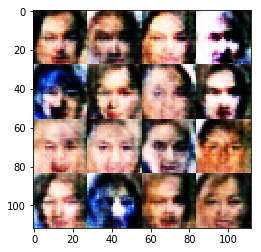

Epoch 1/1... Discriminator Loss: 1.4489... Generator Loss: 0.7666
Epoch 1/1... Discriminator Loss: 1.4215... Generator Loss: 0.7244
Epoch 1/1... Discriminator Loss: 1.4082... Generator Loss: 0.7558
Epoch 1/1... Discriminator Loss: 1.4582... Generator Loss: 0.7178
Epoch 1/1... Discriminator Loss: 1.4302... Generator Loss: 0.7521
Epoch 1/1... Discriminator Loss: 1.4372... Generator Loss: 0.7048
Epoch 1/1... Discriminator Loss: 1.4406... Generator Loss: 0.7503
Epoch 1/1... Discriminator Loss: 1.4218... Generator Loss: 0.7133
Epoch 1/1... Discriminator Loss: 1.4324... Generator Loss: 0.7296
Epoch 1/1... Discriminator Loss: 1.4890... Generator Loss: 0.7016


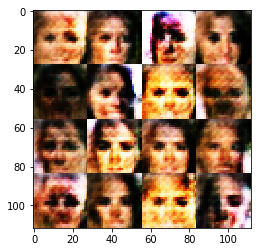

Epoch 1/1... Discriminator Loss: 1.4553... Generator Loss: 0.7463
Epoch 1/1... Discriminator Loss: 1.4088... Generator Loss: 0.7440
Epoch 1/1... Discriminator Loss: 1.4295... Generator Loss: 0.6927
Epoch 1/1... Discriminator Loss: 1.4119... Generator Loss: 0.7270
Epoch 1/1... Discriminator Loss: 1.3640... Generator Loss: 0.7729
Epoch 1/1... Discriminator Loss: 1.4225... Generator Loss: 0.7172
Epoch 1/1... Discriminator Loss: 1.4142... Generator Loss: 0.7200
Epoch 1/1... Discriminator Loss: 1.4466... Generator Loss: 0.7729
Epoch 1/1... Discriminator Loss: 1.4198... Generator Loss: 0.7464
Epoch 1/1... Discriminator Loss: 1.4488... Generator Loss: 0.7467


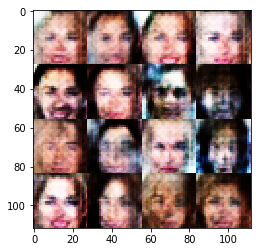

Epoch 1/1... Discriminator Loss: 1.4116... Generator Loss: 0.7400
Epoch 1/1... Discriminator Loss: 1.3799... Generator Loss: 0.7768
Epoch 1/1... Discriminator Loss: 1.4491... Generator Loss: 0.7148
Epoch 1/1... Discriminator Loss: 1.4048... Generator Loss: 0.7661
Epoch 1/1... Discriminator Loss: 1.4350... Generator Loss: 0.7271
Epoch 1/1... Discriminator Loss: 1.4558... Generator Loss: 0.7111
Epoch 1/1... Discriminator Loss: 1.3884... Generator Loss: 0.7336
Epoch 1/1... Discriminator Loss: 1.4180... Generator Loss: 0.7751
Epoch 1/1... Discriminator Loss: 1.4344... Generator Loss: 0.7403
Epoch 1/1... Discriminator Loss: 1.4469... Generator Loss: 0.7730


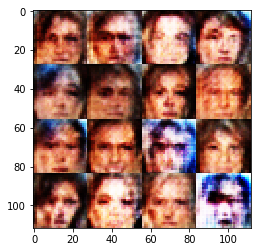

Epoch 1/1... Discriminator Loss: 1.4298... Generator Loss: 0.7297
Epoch 1/1... Discriminator Loss: 1.4779... Generator Loss: 0.7428
Epoch 1/1... Discriminator Loss: 1.4267... Generator Loss: 0.7725
Epoch 1/1... Discriminator Loss: 1.3958... Generator Loss: 0.8161
Epoch 1/1... Discriminator Loss: 1.4673... Generator Loss: 0.7334
Epoch 1/1... Discriminator Loss: 1.4439... Generator Loss: 0.7575
Epoch 1/1... Discriminator Loss: 1.3968... Generator Loss: 0.7589
Epoch 1/1... Discriminator Loss: 1.3963... Generator Loss: 0.7443
Epoch 1/1... Discriminator Loss: 1.4181... Generator Loss: 0.7398
Epoch 1/1... Discriminator Loss: 1.4080... Generator Loss: 0.7227


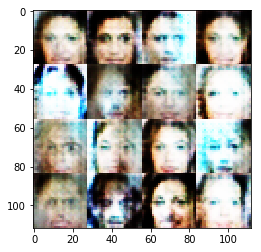

Epoch 1/1... Discriminator Loss: 1.4408... Generator Loss: 0.7218
Epoch 1/1... Discriminator Loss: 1.4097... Generator Loss: 0.7506
Epoch 1/1... Discriminator Loss: 1.4036... Generator Loss: 0.7581
Epoch 1/1... Discriminator Loss: 1.4239... Generator Loss: 0.7494
Epoch 1/1... Discriminator Loss: 1.4233... Generator Loss: 0.7632
Epoch 1/1... Discriminator Loss: 1.4054... Generator Loss: 0.7227
Epoch 1/1... Discriminator Loss: 1.4175... Generator Loss: 0.7499
Epoch 1/1... Discriminator Loss: 1.3838... Generator Loss: 0.7529
Epoch 1/1... Discriminator Loss: 1.4292... Generator Loss: 0.7480
Epoch 1/1... Discriminator Loss: 1.4249... Generator Loss: 0.7745


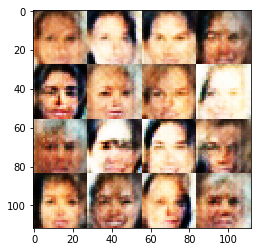

Epoch 1/1... Discriminator Loss: 1.3888... Generator Loss: 0.7716
Epoch 1/1... Discriminator Loss: 1.4330... Generator Loss: 0.7685
Epoch 1/1... Discriminator Loss: 1.4149... Generator Loss: 0.7745
Epoch 1/1... Discriminator Loss: 1.4163... Generator Loss: 0.7417
Epoch 1/1... Discriminator Loss: 1.4139... Generator Loss: 0.7604
Epoch 1/1... Discriminator Loss: 1.4126... Generator Loss: 0.7397
Epoch 1/1... Discriminator Loss: 1.4071... Generator Loss: 0.7253
Epoch 1/1... Discriminator Loss: 1.4007... Generator Loss: 0.7683
Epoch 1/1... Discriminator Loss: 1.4230... Generator Loss: 0.7316
Epoch 1/1... Discriminator Loss: 1.4155... Generator Loss: 0.7651


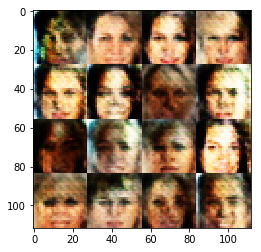

Epoch 1/1... Discriminator Loss: 1.4040... Generator Loss: 0.7605
Epoch 1/1... Discriminator Loss: 1.4304... Generator Loss: 0.7493
Epoch 1/1... Discriminator Loss: 1.4392... Generator Loss: 0.7241
Epoch 1/1... Discriminator Loss: 1.4264... Generator Loss: 0.7255
Epoch 1/1... Discriminator Loss: 1.4103... Generator Loss: 0.7794
Epoch 1/1... Discriminator Loss: 1.3902... Generator Loss: 0.7376
Epoch 1/1... Discriminator Loss: 1.4026... Generator Loss: 0.7897
Epoch 1/1... Discriminator Loss: 1.4208... Generator Loss: 0.7213
Epoch 1/1... Discriminator Loss: 1.4168... Generator Loss: 0.7662
Epoch 1/1... Discriminator Loss: 1.4139... Generator Loss: 0.7523


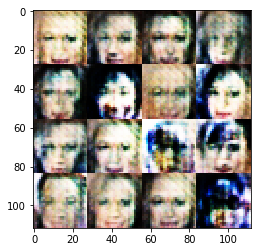

Epoch 1/1... Discriminator Loss: 1.4123... Generator Loss: 0.7367
Epoch 1/1... Discriminator Loss: 1.4268... Generator Loss: 0.7397
Epoch 1/1... Discriminator Loss: 1.4273... Generator Loss: 0.7343
Epoch 1/1... Discriminator Loss: 1.4425... Generator Loss: 0.7473
Epoch 1/1... Discriminator Loss: 1.4133... Generator Loss: 0.7561
Epoch 1/1... Discriminator Loss: 1.4366... Generator Loss: 0.7362
Epoch 1/1... Discriminator Loss: 1.4975... Generator Loss: 0.7198
Epoch 1/1... Discriminator Loss: 1.4101... Generator Loss: 0.7902
Epoch 1/1... Discriminator Loss: 1.3991... Generator Loss: 0.7740
Epoch 1/1... Discriminator Loss: 1.4187... Generator Loss: 0.7514


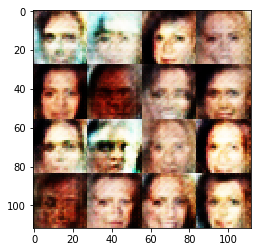

Epoch 1/1... Discriminator Loss: 1.4555... Generator Loss: 0.6927
Epoch 1/1... Discriminator Loss: 1.4140... Generator Loss: 0.7537
Epoch 1/1... Discriminator Loss: 1.3740... Generator Loss: 0.7448
Epoch 1/1... Discriminator Loss: 1.4280... Generator Loss: 0.7476
Epoch 1/1... Discriminator Loss: 1.4150... Generator Loss: 0.7884
Epoch 1/1... Discriminator Loss: 1.4511... Generator Loss: 0.7234
Epoch 1/1... Discriminator Loss: 1.4804... Generator Loss: 0.7225
Epoch 1/1... Discriminator Loss: 1.4492... Generator Loss: 0.7171
Epoch 1/1... Discriminator Loss: 1.4226... Generator Loss: 0.7393
Epoch 1/1... Discriminator Loss: 1.4121... Generator Loss: 0.7258


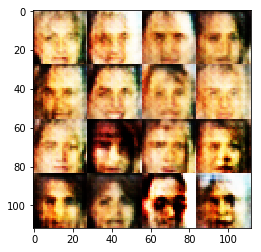

Epoch 1/1... Discriminator Loss: 1.4221... Generator Loss: 0.7631
Epoch 1/1... Discriminator Loss: 1.4107... Generator Loss: 0.7263
Epoch 1/1... Discriminator Loss: 1.4159... Generator Loss: 0.7690
Epoch 1/1... Discriminator Loss: 1.4405... Generator Loss: 0.7225
Epoch 1/1... Discriminator Loss: 1.4084... Generator Loss: 0.7494
Epoch 1/1... Discriminator Loss: 1.4103... Generator Loss: 0.7399
Epoch 1/1... Discriminator Loss: 1.3970... Generator Loss: 0.7911
Epoch 1/1... Discriminator Loss: 1.3908... Generator Loss: 0.7590
Epoch 1/1... Discriminator Loss: 1.3879... Generator Loss: 0.7994
Epoch 1/1... Discriminator Loss: 1.4310... Generator Loss: 0.7229


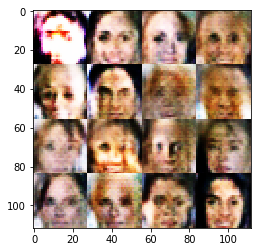

Epoch 1/1... Discriminator Loss: 1.3909... Generator Loss: 0.7521
Epoch 1/1... Discriminator Loss: 1.4531... Generator Loss: 0.7448
Epoch 1/1... Discriminator Loss: 1.4228... Generator Loss: 0.7626
Epoch 1/1... Discriminator Loss: 1.3898... Generator Loss: 0.7668
Epoch 1/1... Discriminator Loss: 1.4165... Generator Loss: 0.7413
Epoch 1/1... Discriminator Loss: 1.4499... Generator Loss: 0.7223
Epoch 1/1... Discriminator Loss: 1.4200... Generator Loss: 0.7303
Epoch 1/1... Discriminator Loss: 1.3974... Generator Loss: 0.7450
Epoch 1/1... Discriminator Loss: 1.3927... Generator Loss: 0.7711
Epoch 1/1... Discriminator Loss: 1.4464... Generator Loss: 0.7253


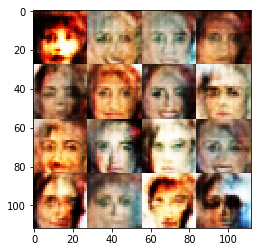

Epoch 1/1... Discriminator Loss: 1.4045... Generator Loss: 0.7199
Epoch 1/1... Discriminator Loss: 1.4016... Generator Loss: 0.7777
Epoch 1/1... Discriminator Loss: 1.4445... Generator Loss: 0.7565
Epoch 1/1... Discriminator Loss: 1.4331... Generator Loss: 0.7306
Epoch 1/1... Discriminator Loss: 1.4263... Generator Loss: 0.7419
Epoch 1/1... Discriminator Loss: 1.4016... Generator Loss: 0.7441
Epoch 1/1... Discriminator Loss: 1.4035... Generator Loss: 0.7711
Epoch 1/1... Discriminator Loss: 1.4277... Generator Loss: 0.7222
Epoch 1/1... Discriminator Loss: 1.4094... Generator Loss: 0.7485
Epoch 1/1... Discriminator Loss: 1.4194... Generator Loss: 0.7751


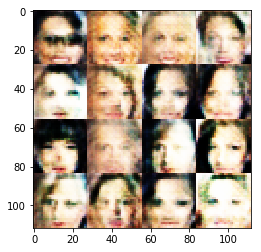

Epoch 1/1... Discriminator Loss: 1.4167... Generator Loss: 0.7423
Epoch 1/1... Discriminator Loss: 1.4160... Generator Loss: 0.7474
Epoch 1/1... Discriminator Loss: 1.4098... Generator Loss: 0.7488
Epoch 1/1... Discriminator Loss: 1.4406... Generator Loss: 0.7294
Epoch 1/1... Discriminator Loss: 1.4217... Generator Loss: 0.7579
Epoch 1/1... Discriminator Loss: 1.4034... Generator Loss: 0.7416
Epoch 1/1... Discriminator Loss: 1.4123... Generator Loss: 0.7335
Epoch 1/1... Discriminator Loss: 1.4535... Generator Loss: 0.7313
Epoch 1/1... Discriminator Loss: 1.4708... Generator Loss: 0.7134
Epoch 1/1... Discriminator Loss: 1.4297... Generator Loss: 0.7369


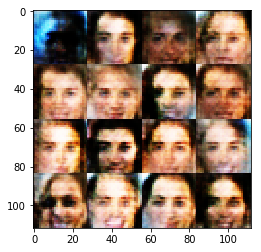

Epoch 1/1... Discriminator Loss: 1.4220... Generator Loss: 0.7391
Epoch 1/1... Discriminator Loss: 1.4419... Generator Loss: 0.7386
Epoch 1/1... Discriminator Loss: 1.4054... Generator Loss: 0.7435
Epoch 1/1... Discriminator Loss: 1.4519... Generator Loss: 0.7664
Epoch 1/1... Discriminator Loss: 1.4063... Generator Loss: 0.7111
Epoch 1/1... Discriminator Loss: 1.3923... Generator Loss: 0.7606
Epoch 1/1... Discriminator Loss: 1.3883... Generator Loss: 0.7610
Epoch 1/1... Discriminator Loss: 1.4083... Generator Loss: 0.7437
Epoch 1/1... Discriminator Loss: 1.4318... Generator Loss: 0.7252
Epoch 1/1... Discriminator Loss: 1.4175... Generator Loss: 0.7613


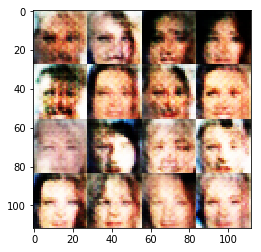

Epoch 1/1... Discriminator Loss: 1.4417... Generator Loss: 0.7449
Epoch 1/1... Discriminator Loss: 1.4098... Generator Loss: 0.7689
Epoch 1/1... Discriminator Loss: 1.4021... Generator Loss: 0.7486
Epoch 1/1... Discriminator Loss: 1.3971... Generator Loss: 0.7548
Epoch 1/1... Discriminator Loss: 1.3842... Generator Loss: 0.7562
Epoch 1/1... Discriminator Loss: 1.3907... Generator Loss: 0.7565
Epoch 1/1... Discriminator Loss: 1.4047... Generator Loss: 0.7458
Epoch 1/1... Discriminator Loss: 1.3959... Generator Loss: 0.7426
Epoch 1/1... Discriminator Loss: 1.3997... Generator Loss: 0.7570
Epoch 1/1... Discriminator Loss: 1.4093... Generator Loss: 0.7817


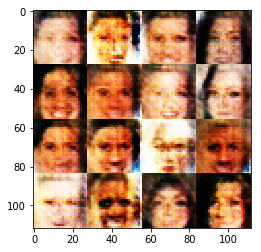

Epoch 1/1... Discriminator Loss: 1.4035... Generator Loss: 0.7239
Epoch 1/1... Discriminator Loss: 1.4228... Generator Loss: 0.7336
Epoch 1/1... Discriminator Loss: 1.4363... Generator Loss: 0.7388
Epoch 1/1... Discriminator Loss: 1.3995... Generator Loss: 0.7642
Epoch 1/1... Discriminator Loss: 1.4030... Generator Loss: 0.7366
Epoch 1/1... Discriminator Loss: 1.4203... Generator Loss: 0.7501
Epoch 1/1... Discriminator Loss: 1.4040... Generator Loss: 0.7658
Epoch 1/1... Discriminator Loss: 1.3968... Generator Loss: 0.7439
Epoch 1/1... Discriminator Loss: 1.4053... Generator Loss: 0.7352
Epoch 1/1... Discriminator Loss: 1.3848... Generator Loss: 0.7780


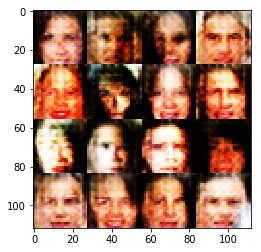

Epoch 1/1... Discriminator Loss: 1.4223... Generator Loss: 0.7723
Epoch 1/1... Discriminator Loss: 1.4421... Generator Loss: 0.7626
Epoch 1/1... Discriminator Loss: 1.4276... Generator Loss: 0.7734
Epoch 1/1... Discriminator Loss: 1.4111... Generator Loss: 0.7413
Epoch 1/1... Discriminator Loss: 1.4404... Generator Loss: 0.7301
Epoch 1/1... Discriminator Loss: 1.4362... Generator Loss: 0.7470
Epoch 1/1... Discriminator Loss: 1.4187... Generator Loss: 0.7572
Epoch 1/1... Discriminator Loss: 1.4264... Generator Loss: 0.7788
Epoch 1/1... Discriminator Loss: 1.4217... Generator Loss: 0.8025
Epoch 1/1... Discriminator Loss: 1.4128... Generator Loss: 0.7511


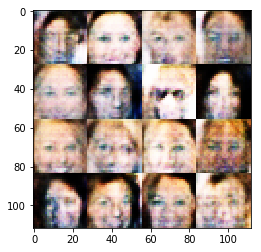

Epoch 1/1... Discriminator Loss: 1.4355... Generator Loss: 0.7281
Epoch 1/1... Discriminator Loss: 1.4064... Generator Loss: 0.7438
Epoch 1/1... Discriminator Loss: 1.3958... Generator Loss: 0.7504
Epoch 1/1... Discriminator Loss: 1.3911... Generator Loss: 0.7425
Epoch 1/1... Discriminator Loss: 1.3924... Generator Loss: 0.7474
Epoch 1/1... Discriminator Loss: 1.3835... Generator Loss: 0.7610
Epoch 1/1... Discriminator Loss: 1.3988... Generator Loss: 0.7661
Epoch 1/1... Discriminator Loss: 1.4037... Generator Loss: 0.7556
Epoch 1/1... Discriminator Loss: 1.3980... Generator Loss: 0.7853
Epoch 1/1... Discriminator Loss: 1.3905... Generator Loss: 0.7579


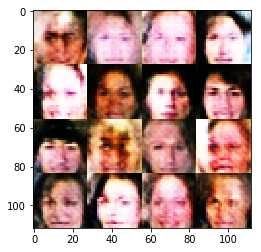

Epoch 1/1... Discriminator Loss: 1.4051... Generator Loss: 0.7439
Epoch 1/1... Discriminator Loss: 1.4021... Generator Loss: 0.7861
Epoch 1/1... Discriminator Loss: 1.4294... Generator Loss: 0.7541


In [ ]:
batch_size = 32
z_dim = 100
learning_rate = 0.0008
beta1 = 0.5


"""
DON'T MODIFY ANYTHING IN THIS CELL THAT IS BELOW THIS LINE
"""
epochs = 1

celeba_dataset = helper.Dataset('celeba', glob(os.path.join(data_dir, 'img_align_celeba/*.jpg')))
with tf.Graph().as_default():
    train(epochs, batch_size, z_dim, learning_rate, beta1, celeba_dataset.get_batches,
          celeba_dataset.shape, celeba_dataset.image_mode)

### Submitting This Project
When submitting this project, make sure to run all the cells before saving the notebook. Save the notebook file as "dlnd_face_generation.ipynb" and save it as a HTML file under "File" -> "Download as". Include the "helper.py" and "problem_unittests.py" files in your submission.